In [197]:
# let's import all the dependencies at once 

from __future__ import print_function
import itertools
import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np
import pandas as pd
import os
import random

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cmatrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.cross_validation import cross_val_score
from sklearn import metrics

#import models
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler


#plots
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.plotly as py
#import plotly.graph_objs as go


ctx = mx.gpu()
mx.random.seed(42)         # fix the random seed for reproducibility
#model_ctx = mx.gpu(0)

In [198]:
### Read the dataset ###

my_cols = pd.read_csv("KDDlabels.csv", header=-1)

### TRAIN ###
df = pd.read_csv("KDDTrain.csv", header=-1)
df.drop(42, axis=1, inplace=True)
df.columns = my_cols[0] 

# we drop this feature because it is always the same
df.drop("num_outbound_cmds", axis = 1, inplace = True)

### TEST ###
test_df = pd.read_csv("KDDTest.csv", header=-1)
test_df.drop(42, axis=1, inplace=True)
test_df.columns = my_cols[0]

# we drop this feature because it is always the same
test_df.drop("num_outbound_cmds", axis = 1, inplace = True)

In [199]:
# we add a column that keeps track if a sample comes from the test or train
df["train"] = True
test_df["train"] = False

In [200]:
mix_df = df.append(test_df)
mix_df.shape

(148516, 42)

In [201]:
mix_df.loc[~mix_df["label"].isin(["neptune","normal"]), "label"] = 1   # everything that is not neptune or normal
mix_df.loc[mix_df["label"] == "neptune", "label"] = 1   # neptune
mix_df.loc[mix_df["label"] == "normal", "label"] = 0   # normal connection

mix_df["label_numeric"] = pd.to_numeric(mix_df["label"])
mix_df = mix_df.drop("label", axis = 1)

In [202]:
mix_df["label_numeric"].value_counts()

0    77053
1    71463
Name: label_numeric, dtype: int64

In [203]:
# we decide to work with only 13 features

f13 = ["duration", "protocol_type", "service", "src_bytes", "dst_bytes",
       "urgent", "count", "srv_count", "same_srv_rate", "dst_host_count",
       "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_same_src_port_rate", "label_numeric", "train"]


restricted_mdf = mix_df.loc[:, f13]
restricted_mdf = pd.get_dummies(data = restricted_mdf, columns = ["protocol_type", "service"])

In [204]:
# creating the test and train dataset
test = restricted_mdf[restricted_mdf["train"] == False]
test.drop("train", axis = 1, inplace = True)
x_test = test.drop("label_numeric", axis = 1)
y_test = test["label_numeric"]

x_darpa = restricted_mdf[restricted_mdf["train"] == True]    #label_n is the numeric version
x_darpa.drop("train", axis=1, inplace=True)
y_darpa = x_darpa["label_numeric"]
x_darpa = x_darpa.drop("label_numeric", axis = 1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [205]:
### NORMALIZATION ###

columns_to_normalize = ["duration", "src_bytes", "dst_bytes", "count", "srv_count", "dst_host_count", "dst_host_srv_count" ]

## TRAIN normalization
x_darpa_copy = x_darpa.copy()
x_darpa_scaled = x_darpa_copy[columns_to_normalize]
scaler = MinMaxScaler().fit(x_darpa_scaled.values)
x_darpa_scaled = scaler.transform(x_darpa_scaled.values)

x_darpa[columns_to_normalize] = x_darpa_scaled


# TEST normalization
x_test_copy = x_test.copy()
x_test_scaled = x_test_copy[columns_to_normalize]
#scaler = MinMaxScaler().fit(x_darpa_scaled.values)
x_test_scaled = scaler.transform(x_test_scaled.values)           #to transform we use the SCALER calculated in the training

x_test[columns_to_normalize] = x_test_scaled

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## ---Three Classes--- ##

### Model to distinguish Normal and Neptune with don't know possibility  ###

In [57]:
x_darpa.shape

(125973, 84)

In [56]:
y_darpa.value_counts()

0    67343
1    41214
2    17416
Name: label_numeric, dtype: int64

In [206]:
# divido in maniera random (comportamento di default)
x_train, x_cv, y_train, y_cv = train_test_split(x_darpa, y_darpa, test_size = 0.2, random_state = 42)

In [207]:
y_train.value_counts()

0    53921
1    46857
Name: label_numeric, dtype: int64

In [208]:
# sample randomly 30000
rows = random.sample(list(y_train.index), 50000)

# set those to a new class, the "don't know" class
y_train.ix[rows] = 2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [209]:
y_train.value_counts()

2    50000
0    27059
1    23719
Name: label_numeric, dtype: int64

# Gluon, Artificial Neural Nets (ANN) #

### MLP ###

In [219]:
batch_s = 256

train_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(x_train.as_matrix(), y_train.as_matrix()), batch_size=batch_s, shuffle=True)
cv_iter  = gluon.data.DataLoader(gluon.data.ArrayDataset(x_cv.as_matrix(), y_cv.as_matrix()), batch_size=batch_s, shuffle=False)
test_iter  = gluon.data.DataLoader(gluon.data.ArrayDataset(x_test.as_matrix(), y_test.as_matrix()), batch_size=batch_s, shuffle=False)

In [220]:
num_hidden = 40  
num_outputs = 3  #quanti il numero delle classi, di certo è importante che non sia meno! 

net = gluon.nn.Sequential()

with net.name_scope():
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

In [221]:
net.collect_params().initialize(mx.init.Normal(sigma = 0.5), ctx = ctx)

In [222]:
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()  # sparse_label=False per specificare one-hot

In [223]:
lr = 0.0003 # learning rate
trainer = gluon.Trainer(net.collect_params(), "adam", {"learning_rate": lr})

In [224]:
# hot evaluation

smoothing_constant = 0.01

def evaluate_accuracy(data_iterator, net):
    
    acc = mx.metric.Accuracy()
    
    loss_avg = 0.0
    cumulative_loss = 0.0
    
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).astype(np.float32)
        label = label.as_in_context(ctx).astype(np.float32)
        
        output = net(data)
        
        loss = loss_f(output, label) 
        predictions = nd.argmax(output, axis = 1)
        acc.update(preds = predictions, labels = label)
                
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = curr_loss if (i == 0) else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
                       
        
    return acc.get()[1], moving_loss

In [225]:
# TRAINING

epochs = 10

loss_evolution_train = []
loss_evolution_cv = []
loss_evolution_test = []

accuracy_evolution_train = []
accuracy_evolution_cv = []
accuracy_evolution_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_iter):
        
        data = data.as_in_context(ctx).astype(np.float32)
        label = label.as_in_context(ctx).astype(np.float32)
        
        with autograd.record():
            output = net(data)
            loss = loss_f(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
    
    
    train_accuracy, train_loss = evaluate_accuracy(train_iter, net)
    cv_accuracy, cv_loss       = evaluate_accuracy(cv_iter, net)
    test_accuracy, test_loss   = evaluate_accuracy(test_iter, net)
    
    # save them for later
    loss_evolution_train.append(train_loss)
    loss_evolution_cv.append(cv_loss)
    loss_evolution_test.append(test_loss)
    
    accuracy_evolution_train.append(train_accuracy)
    accuracy_evolution_cv.append(cv_accuracy)
    accuracy_evolution_test.append(test_accuracy)
    
    
    print("Epoch %s -> Train_acc %s. CV_accuracy %s. Test_acc %s" % (e,  train_accuracy, cv_accuracy, test_accuracy))
      

Epoch 0 -> Train_acc 0.497658219056. CV_accuracy 0.463068069061. Test_acc 0.339795058333
Epoch 1 -> Train_acc 0.500069459604. CV_accuracy 0.705655884104. Test_acc 0.567892472164
Epoch 2 -> Train_acc 0.501845640914. CV_accuracy 0.573526493352. Test_acc 0.437696846028
Epoch 3 -> Train_acc 0.502738692969. CV_accuracy 0.58142488589. Test_acc 0.454509160271
Epoch 4 -> Train_acc 0.502490622953. CV_accuracy 0.353085929748. Test_acc 0.239142971211
Epoch 5 -> Train_acc 0.500337375221. CV_accuracy 0.458662433022. Test_acc 0.304839639799
Epoch 6 -> Train_acc 0.50374089583. CV_accuracy 0.431712641397. Test_acc 0.30213370004
Epoch 7 -> Train_acc 0.505993371569. CV_accuracy 0.640285770986. Test_acc 0.488577385441
Epoch 8 -> Train_acc 0.504564488281. CV_accuracy 0.586465568565. Test_acc 0.429445947744
Epoch 9 -> Train_acc 0.503125682193. CV_accuracy 0.234054375868. Test_acc 0.168034423103


#### plots ####

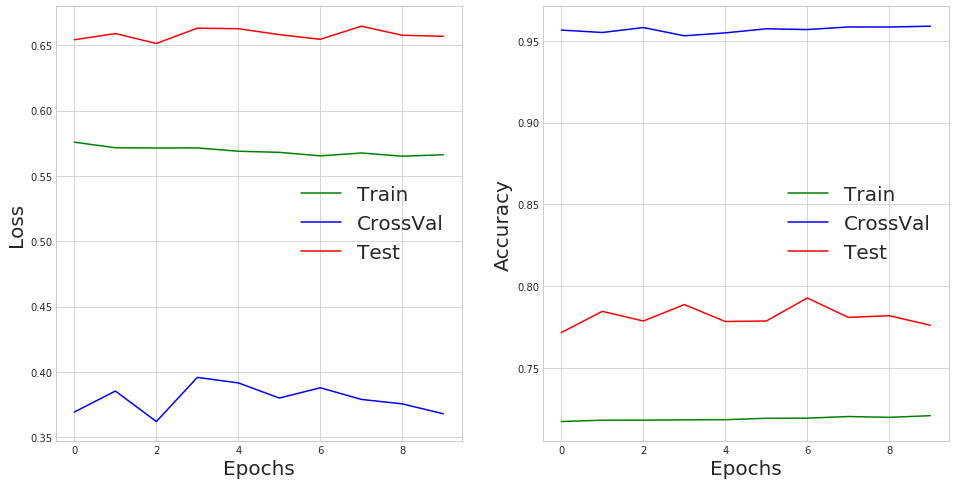

In [128]:
sns.set_style("whitegrid")

plt.figure(figsize=(16, 8))
plt.subplot(121)

plt.plot(loss_evolution_train, color="g")
plt.plot(loss_evolution_cv, color="b")
plt.plot(loss_evolution_test, color="r")    # qui c'è qualcosa che non va.... le curve dovrebbero essere invertite
#plt.title("Comparing Loss Functions", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(["Train", "CrossVal", "Test"], fontsize=20)

plt.subplot(122)
plt.plot(accuracy_evolution_train, color="g")
plt.plot(accuracy_evolution_cv, color="b")
plt.plot(accuracy_evolution_test, color="r")    # qui c'è qualcosa che non va.... le curve dovrebbero essere invertite
#plt.title("Comparing Accuracies", fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend(["Train", "CrossVal", "Test"], fontsize=20)

plt.show()

In [226]:
### COLD EVALUATION ###
# to be run when the neural network is trained

total_correctly_classified = 0 
total_wrongly_classified = 0

predictions_received = []
labels_received = []

for i, (data, label) in enumerate(cv_iter):  # input: train_iter o anche test_iter o cv_iter
    
    currently_correctly_classified = 0
    currently_wrongly_classified = 0
    
    data = data.as_in_context(ctx).astype(np.float32)
    label = label.as_in_context(ctx).astype(np.float32)    

    
    output = net(data) #feed input in the net
    
    ground_output = nd.argmax(output, axis = 1)
    ground_truth  = label
    
    
    for x,y in zip(ground_output, ground_truth):
        
        predictions_received.append(x.asscalar())
        labels_received.append(y.asscalar())
        
        if x.asscalar() == y.asscalar():
            currently_correctly_classified += 1
        else:
            currently_wrongly_classified += 1
        
    #print ("Batch number: %s " %(i + 1), end="")
    #print(currently_correctly_classified, currently_wrongly_classified)
    #print("-" * 40)

    #keep track of global trend
    total_correctly_classified += currently_correctly_classified
    total_wrongly_classified += currently_wrongly_classified   
    
    #resetting variables for next iteration
    currently_correctly_classified = 0
    currently_wrongly_classified = 0
    
print("Total correctly classified samples: %s. Total wrongly classified samples: %s. " %(total_correctly_classified, total_wrongly_classified))

Total correctly classified samples: 5897. Total wrongly classified samples: 19298. 


In [227]:
len(labels_received)

25195

In [228]:
cm = cmatrix(labels_received, predictions_received).T
cm

array([[ 1998,    16,     0],
       [   18,  3899,     0],
       [11406,  7858,     0]])

In [ ]:
array([[8760,    3, 3351],
       [   8, 4576,  484],
       [ 942,   78, 4341]])

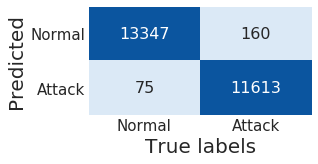

In [56]:
cm = cmatrix(labels_received, predictions_received).T
matrix_evaluation(cm)

# Random Forest (RF) #

Random Forest necessita poco preprocessing delle feature. Il target deve essere numerico sequenziale

In [210]:
# cross validation on the training set
clf = RandomForestClassifier(n_jobs = 4, random_state = 42) #Initialize with whatever parameters you want to

In [211]:
#start random forest training
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [212]:
predictions_cv = clf.predict(x_cv)
predictions_test = clf.predict(x_test)     # raises error because get_dummy creates features number mismatch

In [213]:
predictions_cv

array([2, 1, 1, ..., 2, 2, 1])

In [214]:
predictions_test

array([2, 1, 2, ..., 1, 0, 2])

In [215]:
cm_cv = cmatrix(y_cv, predictions_cv).T
cm_test = cmatrix(y_test, predictions_test).T

In [216]:
y_test.shape

(22543,)

In [217]:
cm_cv

array([[6948,   24,    0],
       [  15, 6318,    0],
       [6459, 5431,    0]])

In [180]:
8875 / (8875 + 4 + 20)

0.9973030677604225

In [103]:
10911 / (10911 + 5)

# ABBIAMO SUI TRUE POSITIVE UNA PRECISION ALTA! OTTIMO

0.9995419567607182

In [218]:
cm_test

array([[4847, 1676,    0],
       [ 163, 4330,    0],
       [4700, 6827,    0]])

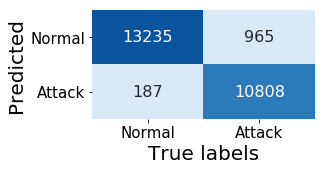

In [91]:
#confusion matrices

matrix_evaluation(cm_cv)
#matrix_evaluation(cm_test)

In [33]:
numeric_evaluation(y_cv, predictions_cv)

NameError: name 'numeric_evaluation' is not defined

In [93]:
numeric_evaluation(y_test, predictions_test)

NameError: name 'y_test' is not defined

# Support Vector Machine (SVM) #

In [94]:
# divido in maniera random tra train e test(comportamento di default)

x_train, x_cv, y_train, y_cv = train_test_split(x_darpa, y_darpa, test_size=0.2, random_state=42)

In [95]:
clf = svm.SVC(gamma = 0.001, C = 100)

In [96]:
# model training
clf.fit(x_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
predictions_cv = clf.predict(x_cv)
#predictions_test = clf.predict(x_test)

In [98]:
cm_cv = cmatrix(y_cv, predictions_cv).T
#cm_test = cmatrix(y_test, predictions_test).T

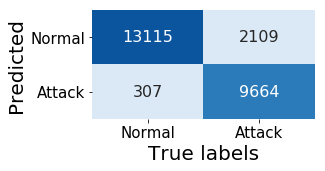

In [99]:
#confusion matrices

matrix_evaluation(cm_cv)
#matrix_evaluation(cm_test)

In [100]:
# in cross-validation
numeric_evaluation(y_cv, predictions_cv)

Accuracy:  0.904108
Precision: [ 0.86146873  0.96921071]
Recall:    [ 0.9771271   0.82086129]
F1:        [ 0.91566013  0.88888889]


In [41]:
# in test
numeric_evaluation(y_test, predictions_test)

Accuracy:  0.982568
Precision: [ 0.97189506  0.99550451]
Recall:    [ 0.99619857  0.96691114]
F1:        [ 0.98389675  0.98099952]


# Logistic Regression (LR) #

puo' essere che funzioni solo con 2 classi

In [28]:
# divido in maniera random tra train e test(comportamento di default)

x_train, x_cv, y_train, y_cv = train_test_split(x_darpa, y_darpa, test_size=0.2, random_state=42)

In [29]:
clf = LogisticRegression(random_state=42)

In [30]:
# model training
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
predictions_cv = clf.predict(x_cv)
predictions_test = clf.predict(x_test)

In [32]:
cm_cv = cmatrix(y_cv, predictions_cv).T
cm_test = cmatrix(y_test, predictions_test).T

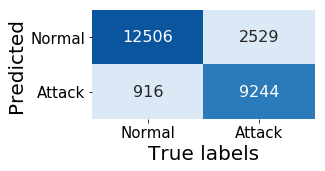

In [33]:
matrix_evaluation(cm_cv)

In [34]:
numeric_evaluation(y_cv, predictions_cv)

Accuracy:  0.863267
Precision: [ 0.83179248  0.90984252]
Recall:    [ 0.93175384  0.78518644]
F1:        [ 0.87894016  0.84293074]


In [35]:
numeric_evaluation(y_test, predictions_test)

Accuracy:  0.866043
Precision: [ 0.83570136  0.91093396]
Recall:    [ 0.93280668  0.78935698]
F1:        [ 0.88158809  0.84579888]


# Naive Bayes #

In [55]:
# divido in maniera random tra train e test(comportamento di default)

x_train, x_cv, y_train, y_cv = train_test_split(x_darpa, y_darpa, test_size=0.2, random_state=42)

In [12]:
clf = GaussianNB()

In [13]:
clf.fit(x_train, y_train)

GaussianNB(priors=None)

In [18]:
predictions_cv = clf.predict(x_cv)
predictions_test = clf.predict(x_test)

In [19]:
cm_cv = cmatrix(y_cv, predictions_cv).T
cm_test = cmatrix(y_test, predictions_test).T

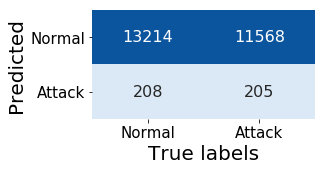

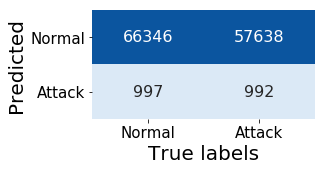

In [22]:
#confusion matrices

matrix_evaluation(cm_cv)
matrix_evaluation(cm_test)

In [23]:
# in cross-validation
numeric_evaluation(y_cv, predictions_cv)

Accuracy:  0.532606
Precision: [ 0.53320959  0.49636804]
Recall:    [ 0.98450305  0.01741272]
F1:        [ 0.69176003  0.03364517]


In [25]:
# in test set
numeric_evaluation(y_test, predictions_test)

Accuracy:  0.534543
Precision: [ 0.53511743  0.49874309]
Recall:    [ 0.98519519  0.01691967]
F1:        [ 0.69353515  0.03272901]


# K Nearest Neighbor (KNN) #

In [79]:
clf = KNeighborsClassifier()
clf.fit(x_train, y_train)

# make predictions
predictions_cv = clf.predict(x_cv)
predictions_test = clf.predict(x_test)

In [80]:
cm_cv = cmatrix(y_cv, predictions_cv).T
cm_test = cmatrix(y_test, predictions_test).T

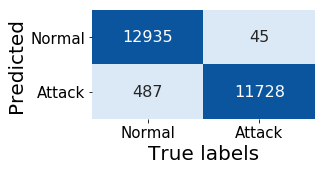

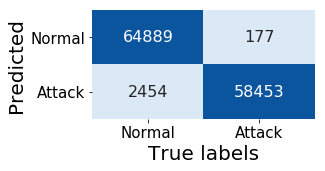

In [81]:
# confusion matrices
matrix_evaluation(cm_cv)
matrix_evaluation(cm_test)

In [82]:
# in cross-validation
numeric_evaluation(y_cv, predictions_cv)

Accuracy:  0.978885
Precision: [ 0.99653313  0.96013099]
Recall:    [ 0.96371629  0.99617769]
F1:        [ 0.97985001  0.97782224]


In [83]:
numeric_evaluation(y_test, predictions_test)

Accuracy:  0.979115
Precision: [ 0.99727969  0.95970906]
Recall:    [ 0.96355969  0.99698107]
F1:        [ 0.98012975  0.97799008]


# Anomaly Detection #


# Evaluation #

In [34]:
# print a nice confusion matrix
def matrix_evaluation(cm):

    fig, ax = plt.subplots(figsize=(4,2))

    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt=".0f", cbar=False, cmap=sns.color_palette("Blues"))

    # labels, title and ticks
    ax.set_xlabel('True labels', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)


    ax.xaxis.set_ticklabels(['Normal', 'Attack'], fontsize=15)
    ax.yaxis.set_ticklabels(['Normal', 'Attack'], fontsize=15)

    plt.yticks(rotation=0)
    plt.show()

def numeric_evaluation(y_cv, predictions):
    
    print("Accuracy:  %f" %accuracy_score(y_cv, predictions))
    print("Precision: %s" %precision_score(y_cv, predictions, average=None))
    print("Recall:    %s" %recall_score(y_cv, predictions, average=None))
    print("F1:        %s" %f1_score(y_cv, predictions, average=None))
    

# Missclassified Analysis #

In [35]:
x_cv_analysis = x_cv.copy()

In [36]:
x_cv_analysis.loc[:, "TRUTH"] = y_cv.copy()
x_cv_analysis.loc[:, "PREDICTION"] = clf.predict(x_cv)
x_cv_analysis.loc[:, "GUESSED"] = x_cv_analysis.loc[:, "TRUTH"] == x_cv_analysis.loc[:, "PREDICTION"]

In [37]:
x_cv_analysis.head()

,duration,src_bytes,dst_bytes,urgent,count,srv_count,same_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,...,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,TRUTH,PREDICTION,GUESSED
378,-0.006692,-0.000033,-0.000015,0,-0.160680,-0.046454,1.00,-0.451564,0.217047,1.00,...,0,0,0,0,0,0,0,0,0,True
32038,-0.006692,-0.000033,-0.000015,0,-0.082402,-0.032755,0.26,0.285690,-0.280992,0.17,...,0,0,0,0,0,0,0,1,1,True
86399,-0.006692,-0.000033,-0.000015,0,0.391179,-0.015143,0.07,0.285690,-0.375110,0.08,...,0,0,0,0,0,0,0,1,1,True
74412,-0.006692,-0.000033,-0.000015,0,0.050670,-0.038626,0.07,0.285690,-0.347659,0.11,...,0,0,0,0,0,0,0,1,1,True
52951,-0.006692,-0.000033,-0.000015,0,-0.162637,-0.052325,1.00,-0.188819,-0.449620,0.01,...,0,0,0,0,0,0,0,1,1,True


In [38]:
x_cv_analysis["GUESSED"].value_counts()

True     25087
False      108
Name: GUESSED, dtype: int64

In [39]:
#show the proability of each prediction
clf.predict_proba(x_cv)

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

### PLOTLY ### 

In [60]:
x_cv.shape

(21712, 79)

In [62]:
X_embedded = TSNE(n_components=3).fit_transform(x_cv, y_cv)

In [64]:
X_embedded.shape

(21712, 3)

In [68]:
X_embedded[:,0].shape

(21712,)

In [78]:
len(predictions_cv)

21712

In [85]:
X_embedded_zero = X_embedded[predictions_cv == 0, :]
X_embedded_one = X_embedded[predictions_cv == 1, :]
X_embedded_two = X_embedded[predictions_cv == 2, :]

In [84]:
X_embedded_zero.shape

(11088, 3)

In [87]:
import numpy as np

#x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x = X_embedded_zero[:,0],
    y = X_embedded_zero[:,1],
    z = X_embedded_zero[:,2],
    mode = 'markers',
    marker = dict(
        size = 6,
        line=dict(
            color='rgba(50, 250, 50, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)


trace2 = go.Scatter3d(
    x = X_embedded_one[:, 0],
    y = X_embedded_one[:, 1],
    z = X_embedded_one[:, 2],
    mode='markers',
    marker=dict(
        color='rgb(250, 50, 50)',
        size=6,
        symbol='circle',
        line=dict(
            color='rgb(250, 50, 50)',
            width=1
        ),
        opacity=0.9
    )
)

trace3 = go.Scatter3d(
    x = X_embedded_two[:, 0],
    y = X_embedded_two[:, 1],
    z = X_embedded_two[:, 2],
    mode='markers',
    marker=dict(
        color='rgb(200, 200, 200)',
        size=6,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)



data = [trace1, trace2, trace3]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')